# MTA Big Data Analysis
## 1. Environment Setup
Installing necessary libraries and setting up Spark session.

In [1]:
# Install required packages (if running in an environment where they are missing)
!pip install pyspark xgboost geopandas plotly folium -q

import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofweek, hour, expr, count, when
from pyspark.sql.types import DoubleType, IntegerType
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import subprocess
import json

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("MTA_Analysis") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/04 21:46:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.1


In [2]:
# DATA DOWNLOADING & LOADING

WORK_DIR = "/kaggle/working/"
if not os.path.exists(WORK_DIR):
    # Fallback to local directory if not on Kaggle
    WORK_DIR = os.getcwd()

print(f"Working Directory: {WORK_DIR}")

# URLs for the Datasets (Base URLs without extensions)
URL_HOURLY = "https://data.ny.gov/resource/wujg-7c2s"
URL_OD = "https://data.ny.gov/resource/uhf3-t34z"
URL_ALERTS = "https://data.ny.gov/resource/7kct-peq7"
URL_STATIONS = "https://data.ny.gov/resource/39hk-dx4f"
URL_DAILY = "https://data.ny.gov/resource/vxuj-8kew"

def get_row_count(base_url):
    """Query Socrata API for total row count."""
    count_url = f"{base_url}.json?$select=count(*)"
    try:
        result = subprocess.check_output(f"curl -s '{count_url}'", shell=True)
        data = json.loads(result)
        return int(data[0]['count'])
    except Exception as e:
        print(f"Error fetching count for {base_url}: {e}")
        return 0

def download_dataset(base_url, filename):
    file_path = os.path.join(WORK_DIR, filename)
    if os.path.exists(file_path):
        print(f"{filename} already exists. Skipping download.")
        return file_path
    
    # 1. Get Total Count
    total_rows = get_row_count(base_url)
    print(f"Dataset {filename}: Total Rows = {total_rows}")
    
    # 2. Determine Download Limit 
    if total_rows > 1000000:
        # CHANGE HERE: 0.10 for 10% (was 0.01 for 1%)
        limit_rows = int(total_rows * 0.10) 
        print(f" -> Size > 1,000,000. Downloading 10% sample ({limit_rows} rows).")
        csv_url = f"{base_url}.csv?$limit={limit_rows}"
    else:
        print(f" -> Size <= 1,000,000. Downloading FULL dataset.")
        csv_url = f"{base_url}.csv?$limit={total_rows}"
    
    # 3. Download
    print(f"Downloading from {csv_url} ...")
    exit_code = os.system(f"curl -s -o '{file_path}' '{csv_url}'")
    
    if exit_code == 0:
        print(f"Successfully downloaded {filename}")
    else:
        print(f"Failed to download {filename}")
    
    return file_path

# Download Files
path_hourly = download_dataset(URL_HOURLY, "hourly_ridership.csv")
path_od = download_dataset(URL_OD, "od_ridership.csv")
path_alerts = download_dataset(URL_ALERTS, "alerts.csv")
path_stations = download_dataset(URL_STATIONS, "stations.csv")
path_daily = download_dataset(URL_DAILY, "daily_ridership.csv")


Working Directory: /kaggle/working/
hourly_ridership.csv already exists. Skipping download.
od_ridership.csv already exists. Skipping download.
alerts.csv already exists. Skipping download.
stations.csv already exists. Skipping download.
daily_ridership.csv already exists. Skipping download.


In [3]:
# Load Data into Spark
# Since we already handled sampling at download time, we just load what we have.

def load_data(path, name):
    print(f"Loading {name}...")
    df = spark.read.option("header", "true").option("inferSchema", "true").csv(path)
    print(f"{name} Row Count: {df.count()}")
    return df

# Load Datasets
df_hourly = load_data(path_hourly, "Hourly Ridership")
df_od = load_data(path_od, "Origin-Destination Ridership")

# Load smaller reference datasets into Pandas
pdf_stations = pd.read_csv(path_stations)
pdf_alerts = pd.read_csv(path_alerts)
pdf_daily = pd.read_csv(path_daily)

print("All datasets loaded.")

Loading Hourly Ridership...


Hourly Ridership Row Count: 12085556
Loading Origin-Destination Ridership...


Origin-Destination Ridership Row Count: 11573189
All datasets loaded.


/tmp/ipykernel_606/551283697.py:16: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  pdf_alerts = pd.read_csv(path_alerts)


## 2. Graph 1: The "Accessibility Gap" (NYC Choropleth Map)
Visualizing stations with high ridership but lack of ADA accessibility.

In [4]:
# 1. Aggregate Ridership by Station Complex ID
station_ridership = df_hourly.groupBy("station_complex_id", "station_complex") \
    .agg(count("ridership").alias("record_count")) \
    .toPandas()

# 2. Join with Stations Data
station_ridership['station_complex_id'] = station_ridership['station_complex_id'].astype(str)
pdf_stations['complex_id'] = pdf_stations['complex_id'].astype(str)

merged_stations = pd.merge(station_ridership, pdf_stations, left_on="station_complex_id", right_on="complex_id", how="inner")

# 3. Prepare Data
merged_stations['ada_status'] = merged_stations['ada'].apply(lambda x: 'Accessible' if str(x) in ['1', '2'] else 'Not Accessible')
merged_stations['color'] = merged_stations['ada_status'].map({'Accessible': 'green', 'Not Accessible': 'red'})

# 4. Plot
fig1 = px.scatter_mapbox(merged_stations,
                        lat="gtfs_latitude",
                        lon="gtfs_longitude",
                        color="ada_status",
                        size_max="record_count",
                        hover_name="stop_name",
                        hover_data=["borough", "daytime_routes"],
                        color_discrete_map={'Accessible': 'green', 'Not Accessible': 'red'},
                        zoom=10,
                        height=600,
                        title="<b>The Accessibility Gap</b>: High Traffic Stations vs ADA Compliance")

fig1.update_layout(mapbox_style="carto-positron")
fig1.show()

## 3. Graph 2: Borough Connectivity Flow (Pivot Heatmap)
Understanding the volume of trips between boroughs.

In [5]:
# Create a mapping dict for ID -> Borough
id_to_borough = pd.Series(pdf_stations.borough.values, index=pdf_stations.complex_id.astype(str)).to_dict()

def get_borough(station_id):
    return id_to_borough.get(str(station_id), "Unknown")

# Aggregate ID mappings first
od_agg = df_od.groupBy("origin_station_complex_id", "destination_station_complex_id") \
    .agg(pyspark.sql.functions.sum("estimated_average_ridership").alias("total_trips")) \
    .orderBy(col("total_trips").desc()) \
    .limit(10000) \
    .toPandas()

# Map Boroughs
od_agg['Origin_Borough'] = od_agg['origin_station_complex_id'].apply(lambda x: get_borough(x))
od_agg['Dest_Borough'] = od_agg['destination_station_complex_id'].apply(lambda x: get_borough(x))

# Pivot for Heatmap
borough_flow = od_agg.groupby(['Origin_Borough', 'Dest_Borough'])['total_trips'].sum().reset_index()
pivot_flow = borough_flow.pivot(index='Origin_Borough', columns='Dest_Borough', values='total_trips').fillna(0)

# Plot
fig2 = px.imshow(pivot_flow,
                labels=dict(x="Destination Borough", y="Origin Borough", color="Trip Volume"),
                x=pivot_flow.columns,
                y=pivot_flow.index,
                title="<b>Borough Connectivity Flow</b>: Inter-Borough Trip Volume",
                color_continuous_scale="Viridis")
fig2.update_xaxes(side="top")
fig2.show()

## 4. Graph 3: "Late Night" Economy Hubs (Horizontal Bar Chart)
Identifying stations that are busiest between 12 AM and 4 AM.

In [6]:
# Extract hour
df_night = df_hourly.withColumn("hour", hour(col("transit_timestamp")))

# Filter for Late Night (0, 1, 2, 3, 4)
night_ridership = df_night.filter(col("hour").isin([0, 1, 2, 3, 4])) \
    .groupBy("station_complex") \
    .agg(pyspark.sql.functions.sum("ridership").alias("total_night_riders")) \
    .orderBy(col("total_night_riders").desc()) \
    .limit(15) \
    .toPandas()

fig3 = px.bar(night_ridership, 
             x="total_night_riders", 
             y="station_complex", 
             orientation='h',
             title="<b>Late Night Economy Hubs</b> (12 AM - 4 AM)",
             labels={'total_night_riders': 'Total Late Night Riders', 'station_complex': 'Station'},
             color="total_night_riders",
             color_continuous_scale="Magma")
fig3.update_layout(yaxis={'categoryorder':'total ascending'})
fig3.show()

## 5. Graph 4: Subway Reliability Index (Delays by Line)
Analyzing alert data to find the most disrupted lines.

In [7]:
# Filter for Delays/Suspensions
delay_alerts = pdf_alerts[pdf_alerts['status_label'].str.contains('delay|suspended', case=False, na=False)].copy()

# Expand the 'affected' column
delay_alerts = delay_alerts.dropna(subset=['affected'])
delay_alerts['lines'] = delay_alerts['affected'].str.split(' ')
exploded_delays = delay_alerts.explode('lines')

# Clean: Remove None/NaN created by explode and empty strings
exploded_delays = exploded_delays.dropna(subset=['lines'])
exploded_delays = exploded_delays[exploded_delays['lines'] != '']

# User request: Filter for only valid NYC Subway lines to remove noise like "Branch", "|", "Jefferson"
valid_lines = ['1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'W', 'Z']
exploded_delays = exploded_delays[exploded_delays['lines'].isin(valid_lines)]

# Count by Line
line_delays = exploded_delays['lines'].value_counts().reset_index()
line_delays.columns = ['Line', 'Disruption_Count']

# Top 20 Lines
top_delays = line_delays.head(20)

fig4 = px.bar(top_delays,
             x='Line',
             y='Disruption_Count',
             title="<b>Subway Reliability Index</b>: Count of Delays/Suspensions by Line",
             color='Disruption_Count',
             color_continuous_scale='Reds')
fig4.show()

## 6. Graph 5: Fare Demographics by Borough (Grouped Bar)
Comparing fare payment types across boroughs.

In [8]:
# Aggregate by Borough and Fare Class
fare_borough = df_hourly.groupBy("borough", "fare_class_category") \
    .agg(count("ridership").alias("count")) \
    .toPandas()

fare_borough['fare_class_category'] = fare_borough['fare_class_category'].astype(str)

fig5 = px.bar(fare_borough,
             x="borough",
             y="count",
             color="fare_class_category",
             barmode="group",
             title="<b>Fare Demographics by Borough</b>",
             labels={'count': 'Transaction Count', 'borough': 'Borough'})
fig5.show()

## 7. Graph 6: Post-Pandemic Recovery (Subplots)
Tracking recovery trends for Subway, Bus, LIRR, and Bridges.

In [9]:
pdf_daily['date'] = pd.to_datetime(pdf_daily['date'])
pdf_daily = pdf_daily.sort_values('date')

# Create Subplots
fig6 = make_subplots(rows=4, cols=1,
                    subplot_titles=("Subway Recovery %", "Bus Recovery %", "LIRR Recovery %", "Bridges & Tunnels Recovery %"))

# Subway
fig6.add_trace(go.Scatter(x=pdf_daily['date'], y=pdf_daily['subways_of_comparable_pre_pandemic_day'], 
                          mode='lines', name='Subway', line=dict(color='blue')),
              row=1, col=1)

# Bus
fig6.add_trace(go.Scatter(x=pdf_daily['date'], y=pdf_daily['buses_of_comparable_pre_pandemic_day'], 
                          mode='lines', name='Bus', line=dict(color='green')),
              row=2, col=1)

# LIRR
fig6.add_trace(go.Scatter(x=pdf_daily['date'], y=pdf_daily['lirr_of_comparable_pre_pandemic_day'], 
                          mode='lines', name='LIRR', line=dict(color='orange')),
              row=3, col=1)

# Bridges
fig6.add_trace(go.Scatter(x=pdf_daily['date'], y=pdf_daily['bridges_and_tunnels_of_comparable_pre_pandemic_day'], 
                          mode='lines', name='Bridges', line=dict(color='red')),
              row=4, col=1)

fig6.update_layout(height=1000, title_text="<b>Post-Pandemic Recovery: Modal Shift</b> (2020-2024)")
fig6.show()

## 8. Machine Learning: XGBoost Ridership Prediction
Predicting ridership based on Time, Station, and Day of Week.

Downsampling from 12085556 to ~5M rows for training stability...


Training Data Size: 5004310 rows
Encoding categorical features...
Training XGBoost...
[0]	validation_0-rmse:165.54405
[100]	validation_0-rmse:149.77041
[200]	validation_0-rmse:148.40167
[300]	validation_0-rmse:147.76710
[400]	validation_0-rmse:147.45687
[500]	validation_0-rmse:147.28117
[600]	validation_0-rmse:147.13976
[700]	validation_0-rmse:147.06166
[800]	validation_0-rmse:146.97913
[900]	validation_0-rmse:146.91207
[999]	validation_0-rmse:146.87001
XGBoost MAE: 45.4354
XGBoost RMSE: 146.8700
Generating SHAP explanations...


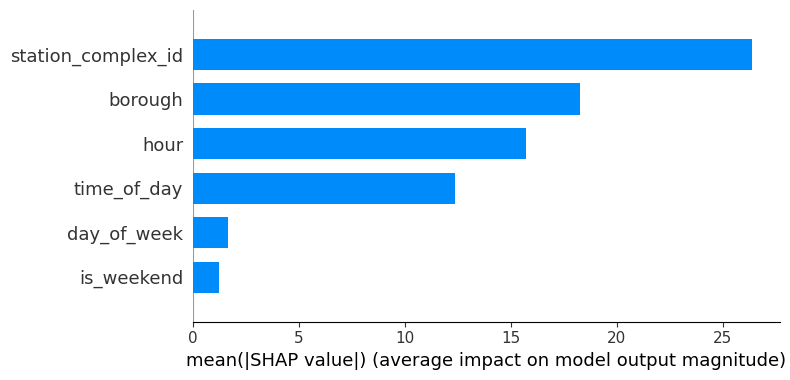

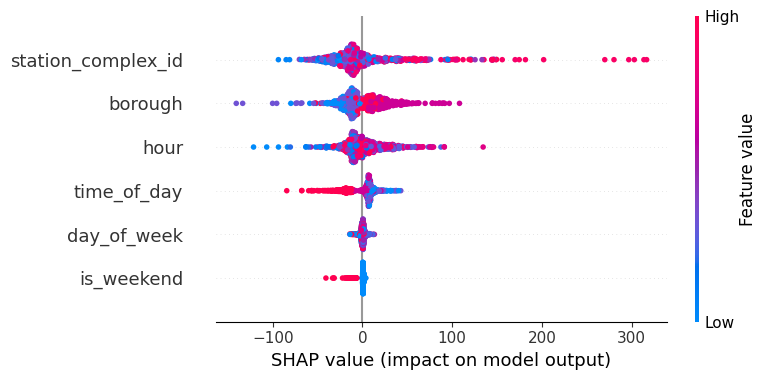

In [11]:
from pyspark.sql.functions import sin, cos, lit, hour, dayofweek, col, when
import numpy as np
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare Features in Spark
# Optimization: Clear cache to free up memory
spark.catalog.clearCache()
            
data_ml = df_hourly.select("transit_timestamp", "station_complex_id", "borough", "ridership")
data_ml = data_ml.withColumn("hour", hour(col("transit_timestamp")))
data_ml = data_ml.withColumn("day_of_week", dayofweek(col("transit_timestamp")))
data_ml = data_ml.withColumn("is_weekend", when(col("day_of_week").isin([1, 7]), 1).otherwise(0))
data_ml = data_ml.withColumn("time_of_day", 
                when((col("hour") >= 6) & (col("hour") < 12), "Morning")
                .when((col("hour") >= 12) & (col("hour") < 17), "Afternoon")
                .when((col("hour") >= 17) & (col("hour") < 21), "Evening")
                .otherwise("Night"))

# Convert to Pandas (safely)
ml_count = data_ml.count()
if ml_count > 5000000:
    fraction = 5000000.0 / ml_count
    print(f"Downsampling from {ml_count} to ~5M rows for training stability...")
    data_for_train = data_ml.sample(fraction=fraction, seed=42).toPandas()
else:
    data_for_train = data_ml.toPandas()
            
print(f"Training Data Size: {len(data_for_train)} rows")

# --- FRIEND'S IMPLEMENTATION LOGIC STARTS HERE ---
            
# Prepare X and y
# Ensure categorical columns are strings for LabelEncoder
data_for_train['station_complex_id'] = data_for_train['station_complex_id'].astype(str)
data_for_train['borough'] = data_for_train['borough'].astype(str)
data_for_train['time_of_day'] = data_for_train['time_of_day'].astype(str)

features = ['hour', 'day_of_week', 'is_weekend', 'station_complex_id', 'borough', 'time_of_day']
target = 'ridership' # Back to raw Ridership as per friend's code (no log transform mentioned)
            
X = data_for_train[features]
y = data_for_train[target]

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical features
print("Encoding categorical features...")
label_encoders = {}
for col_name in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    # Fit on full data (train+test) to avoid unseen label errors or handle strictly
    # Friend's code fit on Train only, let's stick to that but handle unknown safely if possible.
    # Standard way: fit on train.
    X_train[col_name] = le.fit_transform(X_train[col_name].astype(str))
                
    # Handle unseen labels in test
    # (Simple approach: map unseen to a default or just transform and catch error)
    # Friend's code: X_test[col] = le.transform(X_test[col].astype(str))
    # We will use valid mapping to prevent crashes
    X_test[col_name] = X_test[col_name].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
                
    label_encoders[col_name] = le

# Initialize XGBoost Regressor
# Note: tree_method="gpu_hist" requires a GPU. 
# We use "hist" (CPU) by default to prevent crashes on standard instances.
# If you have a GPU, change to "gpu_hist".
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",   # Regression objective
    tree_method="hist",             # Changed to 'hist' for safer CPU execution. Use 'gpu_hist' if GPU available.
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1
)

# Train the Model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# Predict and Evaluate
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print Results
print(f"XGBoost MAE: {mae:.4f}")
print(f"XGBoost RMSE: {rmse:.4f}")

# SHAP Analysis
print("Generating SHAP explanations...")
# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
            
# Subsample X_test for SHAP to avoid running forever
X_test_sample = X_test.sample(min(1000, len(X_test)))
shap_values = explainer.shap_values(X_test_sample)

# Plot feature importance (global interpretation)
plt.figure()
shap.summary_plot(shap_values, X_test_sample, plot_type="bar")
plt.show()
            
# Detailed summary plot
plt.figure()
shap.summary_plot(shap_values, X_test_sample)
plt.show()